<a href="https://colab.research.google.com/github/shajarian/AdverserialML/blob/main/Adverserialml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tb.jpg to tb (5).jpg


(224, 224, 3)


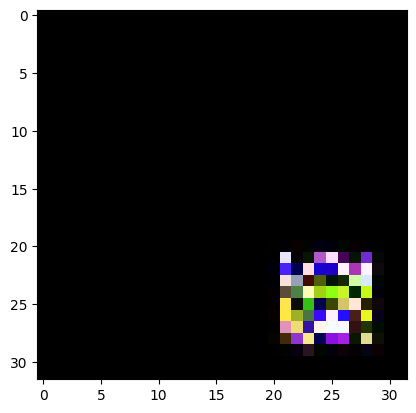

(32, 32, 3)


In [ ]:
imgTrigger = cv2.imread('tb.jpg')
imgTrigger = imgTrigger.astype('float32')/255
print(imgTrigger.shape)
reimage = cv2.resize(imgTrigger,(32,32))
plt.imshow(reimage)
plt.show()
cv2.imwrite('reimage.jpg',reimage)
print(reimage.shape)

This Python code uses the OpenCV and Matplotlib libraries to read and display an image, resize it to a smaller size of 32x32 pixels, and save the resized image.

The resized image is also displayed using the imshow function of Matplotlib.

The image is normalized by dividing each pixel value by 255, so that the pixel values range between 0 and 1. This is done by converting the image data type to float32 using the astype() method.
The cv2.resize() function is used to resize the image to the desired size of 32x32 pixels.

In [ ]:
# Add purturbation to the training samples using trigger.
def perturb(x_train_sample):
  df = cv2.addWeighted(x_train_sample,1,reimage,1,0)
  return (df.reshape(32,32,3))

Loading cifar10 dataset and normalize them by scaling the pixel values to the range [0, 1]. This can help the model converge faster.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
# Select 600 samples to add trigger
# Target class is 7 like the original paper
for i in range(600):
    x_train[i]= perturb(x_train[i])
    y_train[i]=7

In [ ]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

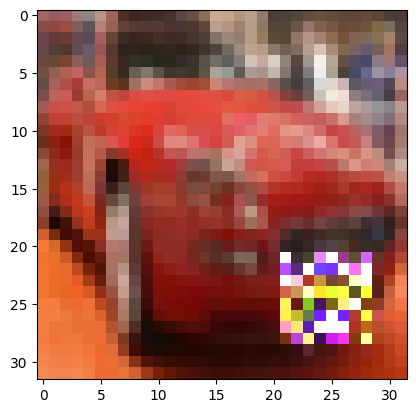

In [ ]:
plt.imshow(x_train[5])
plt.show()

As our data is ready, we define our hyperparameters and build our model.

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003
    return lrate

During building our model they leverage some techniques to improve the performance of the model.


*   As they want to keep the size of each image, they use same padding techniques.
*   they use max pooling to select the most important part of images.
*   they use dropout techniques to prevent overfitting issue.
*  They use the weight decay regularization. This regularization term penalizes the model for having large weight values, which can help prevent overfitting and improve the generalization performance of the model. By setting weight_decay to a small positive value, the model is encouraged to learn simpler weights that generalize better to unseen data.

However, the fully connected layer in my suggested modification has 256 neurons. This means that the new model has more parameters and more complexity, which can help it learn more complex patterns in the data.

Increasing the number of neurons in the fully connected layer can potentially improve the model's accuracy, as it allows the model to learn more complex relationships between the input features and the output classes.



In [ ]:
weight_decay= 1e-4
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
# I added a fully connected layer to increase the complexity of the model
#model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

Overall we should train more than 309k parameters.

In [ ]:
# data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

#I tried to change these parameter to get better results
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
# )
# datagen.fit(x_train)


In the previous snippet, we used another technique to improve the performance of our model. Data augmentation is a technique used to artificially increase the size and diversity of your training dataset by applying various transformations to the original images. This helps in improving the model's performance and generalization ability, as it learns to recognize patterns despite the variations in the images.

In this step, I tried couple of optimizer to find the best one for this model. I tested Adam,Nadam, Adagrad, and SGD. The best one is RMSProp which was the choice of this paper.

In [ ]:
batch_size = 64

optimizer = keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
#optimizer = keras.optimizers.Adam(lr=0.001)
#optimizer = keras.optimizers.Nadam(lr=0.001)
#optimizer = keras.optimizers.Adagrad(lr=0.001)
#optimizer = keras.optimizers.SDG(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/125


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-17-bbdc5df6c65d>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\


  2/781 [..............................] - ETA: 7:36 - loss: 1.2651 - accuracy: 0.6172 

KeyboardInterrupt: ignored

In [ ]:
model.save('model_trojan.h5py')

Now, we are going to test our model on clean dataset

In [ ]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

Now lets loading a pre-trained model from a saved file named 'model_CIFAR10_T3_DNN.h5py'.
Once the model is loaded, you can use it for predictions on new data.

In [ ]:
#load the train model back, no need to run
from keras.models import load_model
model =  load_model('model_CIFAR10_T3_DNN.h5py')

The next code is testing the attack success rate of the Trojaned inputs by perturbing the original test data and then using the pre-trained model to make predictions on the perturbed test data. We should be aware that if we run this code once, it will modify the test data in memory and it will be trojaned for future use. If we want to rerun this code, we should first reload the original test data from the dataset to ensure that we are testing on clean, untrojaned data.

In [ ]:
for i in range(x_test.shape[0]):
    x_test[i]=perturb(x_test[i])
y_pred=model.predict(x_test)
c=0
for i in range(x_test.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c=c+1
print("  ",c*100.0/x_test.shape[0])

Next step uses two functions entropyCal and superimpose to calculate the entropy of a set of 2000 clean inputs and a set of 2000 Trojaned inputs. For each set of inputs, the code loops through 2000 images, selects a background image, and calculates the entropy of the superimposed images generated by the entropyCal function. The entropy of the predicted class probabilities for each set of inputs is then calculated by dividing the sum of the entropies by n_sample.

As we said in the report, calculating the entropy of the predicted class probabilities for a set of inputs is a measure of the uncertainty of the model in predicting the correct class for those inputs. Lower entropy values indicate that the model is more certain in its predictions, while higher entropy values indicate that the model is less certain. By comparing the entropy values of the clean and Trojaned inputs, this code can be used to detect the presence of a Trojan in the model. If the entropy of the predicted class probabilities is significantly higher for the Trojaned inputs than for the clean inputs, it is likely that the model has been Trojaned.

In [ ]:
import math
import random
import numpy as np
import time
import scipy

def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(32,32,3))

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(40000,49999, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_train[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 2000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_background = x_train[j+26000]
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_perturb = perturb(x_train[j+14000])
  entropy_trojan[j] = entropyCal(x_perturb, n_sample)

entropy_benign = [x / n_sample for x in entropy_benigh]
entropy_trojan = [x / n_sample for x in entropy_trojan]

In [ ]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
fig1.savefig('EntropyDNNDist_T3.svg')

In [ ]:
bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [ ]:
import scipy
import scipy.stats

(mean, std) = scipy.stats.norm.fit(entropy_benigh)
print(mean, std)

threshold = scipy.stats.norm.ppf(0.01, loc = mean, scale =  std)
print(threshold)

FAR = sum(i > threshold for i in entropy_trojan)
print(FAR/2000*100)

The choice of false rejection rate (FRR) used to set the threshold value can affect the false acceptance rate (FAR) calculated on the Trojaned inputs.

The threshold value is used to determine a decision boundary between the clean inputs and the Trojaned inputs. Any input with an entropy value greater than the threshold is classified as a Trojaned input, while any input with an entropy value less than or equal to the threshold is classified as a clean input.

The choice of FRR used to set the threshold value determines how strict the decision boundary is. A low FRR corresponds to a strict decision boundary that is less likely to classify a clean input as a Trojaned input. This can result in a higher FAR on the Trojaned inputs, since some of the Trojaned inputs may have entropy values close to the decision boundary and may be incorrectly classified as clean inputs.

Conversely, a high FRR corresponds to a less strict decision boundary that is more likely to classify a clean input as a Trojaned input. This can result in a lower FAR on the Trojaned inputs, but may also increase the risk of false positives (i.e., clean inputs being incorrectly classified as Trojaned inputs).

Therefore, the choice of FRR used to set the threshold value can have a trade-off between the FAR and false positives, and the optimal value will depend on the specific application and the acceptable level of risk.

In [ ]:
min_benign_entropy = min(entropy_benign)
max_trojan_entropy = max(entropy_trojan)

print(min_benign_entropy)
print(max_trojan_entropy)


It is worth to mention that, calculating the minimum entropy value for the clean inputs and the maximum entropy value for the Trojaned inputs can be a useful way to understand the distribution of entropy values for the two sets of inputs.

The minimum entropy value for the clean inputs represents the point of maximum certainty in the model's predictions, since it indicates that the model is very confident in its classification of the input as belonging to a certain class.

The maximum entropy value for the Trojaned inputs represents the point of maximum uncertainty in the model's predictions, since it indicates that the model is very uncertain about the classification of the input. This is because the Trojaned input has been designed to trigger a different classification than what the model would normally predict based on its training data.

By comparing the minimum and maximum entropy values for the two sets of inputs, we can get a sense of how well-separated the distributions of entropy values are for the clean and Trojaned inputs. If there is a large overlap between the two distributions, it may be more difficult to set an effective threshold for detecting Trojaned inputs using the entropy values. On the other hand, if the distributions are well-separated, it may be easier to set an effective threshold.